# imports:

In [1]:
from os import listdir,mkdir,makedirs
from os.path import isfile, join, isdir,exists
import pandas as pd
import numpy as np
from scipy import stats
import re
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from myplots import roundup, rounddown, find_decimal_fold, percentile_cut_off, rarefaction_calc, rarefaction_plot,draw_correlation_scatter
from matplotlib.ticker import FormatStrFormatter
import cPickle as pickle
from Bio.SeqUtils import GC
import seaborn as sns
import random
from scipy.stats import pearsonr,fisher_exact
from skbio.diversity.alpha import shannon, simpson, berger_parker_d

from pop_organize import get_sample_data, get_sample_with_dfs
from SufficientStatistics import *
from MyFunctionsShani import *
import math
from myplots import roundup, rounddown, find_decimal_fold
from skbio.stats.distance import mantel
from scipy.spatial.distance import braycurtis, pdist, euclidean


from GeneralFeaturePhenotypeInteractions.Feature_phenotype_functions import * 
from TCR_microbiome_interactions.TCR_microbiome_interactions_functions import *
from TCR_microbiome_interactions.TCR_microbiome_interactions_functions2 import *
from SampleLists.SampleFileFunctions import *
from PhenotypicData.PhenotypeGenerationFunctions import *
from CardioProject.CardioFunctions import *
from PredictionPipeline.PredictionFunctions import *
from TCR_feature_generation.SubsamplingFunctions import *

import os
from Utils import cacheOnDisk
from SegalQueue.qp import qp,fakeqp
from addloglevels import sethandlers

#ML imports:
from xgboost import XGBClassifier
import lightgbm as lgb
from collections import OrderedDict
from sklearn.model_selection import GroupKFold,StratifiedKFold, KFold
import statsmodels.formula.api as sm
from sklearn.linear_model import LogisticRegression, LinearRegression
import shap
from sklearn import metrics, preprocessing
from sklearn.svm import LinearSVC
from sklearn.feature_selection import SelectFromModel,SelectKBest,chi2,mutual_info_classif,f_classif
from sklearn.naive_bayes import GaussianNB

MyPath='/net/mraid08/export/genie/Lab/Personal/ShaniBAF'

with open('/net/mraid08/export/genie/Lab/Personal/ShaniBAF/Sample files/BD lists/PNP530','rb') as fp:
    PNP530=pickle.load(fp)
with open('/net/mraid08/export/genie/Lab/Personal/ShaniBAF/Sample files/BD lists/Cardio126','rb') as fp:
    Cardio126=pickle.load(fp)
PNP530Cardio126=PNP530+Cardio126


done1
stop
stop
done1
stop
done
done
done
done
stop
stop
end of function!!!


/usr/wisdom/python/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


end of function!!!


In [2]:
import time
cdate=str(time.strftime("%d%m%Y"))
cdate

'11112018'

# generate new feature matrices:

## seperate VDJ from rep features and delete all T features

In [3]:
#load full X:
f='allTCRfeatures_percShared10__withRels.dat'
folder='%s/TCR_real_data/Predictions/featureDFs/' %MyPath
f1=folder+f

df=pd.read_pickle(f1)
print ('df shape before processing is', df.shape)

## delete all _T columns
for col in df.columns:
    if col.endswith('_T'):
        df=df.drop(col,axis=1)
    
print ('df shape after _T removal is', df.shape)


## remove all VDJ_0 and VDJ_1 columns to new df
suffix_list=['0','1']
VDJ_df=pd.DataFrame(index=df.index)
df_list=[]
for suffix in suffix_list:
    regexList = [('vFamily', 'V.._%s' %suffix), ('vGene', 'V..-.._%s' %suffix), ('jGene', 'J..-.._%s' %suffix),
                 ('dFamily', 'D.._%s' %suffix), ('VJ', 'V.._J.._%s' %suffix), ('DJ', 'D.._J..-.._%s' %suffix)]
    for regex in regexList:
        print regex
        regex_item = re.compile(regex[1])
        indices = [n for n in df.columns if re.match(regex_item, n)]
        if regex[0] == 'VJ':
            if 'VA_J01_%s' %suffix in df.columns:
                indices=indices+['VA_J01_%s' %suffix]
        df2 = df.loc[:,indices]
        print 'sample sum:'
        print df2.sum(axis=1).head(10)
#         print df2.iloc[:4,:4]
        df=df.drop(indices,axis=1)
        df_list.append(df2)
        VDJ_df=pd.merge(VDJ_df,df2,how='inner',left_index=True,right_index=True)
           
print ('df shape after processing is', df.shape)
print ('VDJ_df shape after processing is', VDJ_df.shape)

('df shape before processing is', (656, 658))
('df shape after _T removal is', (656, 455))
('vFamily', 'V.._0')
sample sum:
BD406    0.729657
BD228    0.685586
BD714    0.705802
BD808    0.747204
BD144    0.752444
BD617    0.729953
BD143    0.760222
BD195    0.697622
BD673    0.754687
BD401    0.712963
dtype: float64
('vGene', 'V..-.._0')
sample sum:
BD406    0.997983
BD228    0.998775
BD714    0.997952
BD808    0.998881
BD144    0.999302
BD617    0.998821
BD143    0.999307
BD195    0.998393
BD673    1.000000
BD401    0.998457
dtype: float64
('jGene', 'J..-.._0')
sample sum:
BD406    1.0
BD228    1.0
BD714    1.0
BD808    1.0
BD144    1.0
BD617    1.0
BD143    1.0
BD195    1.0
BD673    1.0
BD401    1.0
dtype: float64
('dFamily', 'D.._0')
sample sum:
BD406    1.0
BD228    1.0
BD714    1.0
BD808    1.0
BD144    1.0
BD617    1.0
BD143    1.0
BD195    1.0
BD673    1.0
BD401    1.0
dtype: float64
('VJ', 'V.._J.._0')
sample sum:
BD406    0.997983
BD228    0.999183
BD714    0.998635
BD808    

In [4]:
# save small rep feature:
folder='%s/TCR_real_data/Predictions/featureDFs/' %MyPath

F1='allTCRfeatures_percShared10__withRels_noT.dat'
f1=folder+F1
df.to_pickle(f1)

F2='allTCRfeatures_percShared10__withRels_noT.xlsx'
f2=folder+F2
df.to_excel(f2)

In [5]:
df.columns.tolist()

['AA count_0',
 'AA count_1',
 'NT count_0',
 'NT count_1',
 'berger_aa_0',
 'berger_aa_1',
 'berger_nt_0',
 'berger_nt_1',
 'cdr3Length_max_0',
 'cdr3Length_max_1',
 'cdr3Length_mean_0',
 'cdr3Length_mean_1',
 'cdr3Length_std_0',
 'cdr3Length_std_1',
 'count (templates)_max_0',
 'count (templates)_max_1',
 'count (templates)_mean_0',
 'count (templates)_mean_1',
 'count (templates)_std_0',
 'count (templates)_std_1',
 'd3Deletion_mean_0',
 'd3Deletion_mean_1',
 'd3Deletion_std_0',
 'd3Deletion_std_1',
 'd5Deletion_mean_0',
 'd5Deletion_mean_1',
 'd5Deletion_std_0',
 'd5Deletion_std_1',
 'frequencyCount (%)_max_0',
 'frequencyCount (%)_max_1',
 'frequencyCount (%)_mean_0',
 'frequencyCount (%)_mean_1',
 'frequencyCount (%)_std_0',
 'frequencyCount (%)_std_1',
 'gc_content_0',
 'gc_content_1',
 'jDeletion_max_0',
 'jDeletion_max_1',
 'jDeletion_mean_0',
 'jDeletion_mean_1',
 'jDeletion_std_0',
 'jDeletion_std_1',
 'max_nt_per_aa_0',
 'max_nt_per_aa_1',
 'mean_nt_per_aa_0',
 'mean_nt_per_aa_1',
 'n1Insertion_max_0',
 'n1Insertion_max_1',
 'n1Insertion_mean_0',
 'n1Insertion_mean_1',
 'n1Insertion_std_0',
 'n1Insertion_std_1',
 'n2Insertion_max_0',
 'n2Insertion_max_1',
 'n2Insertion_mean_0',
 'n2Insertion_mean_1',
 'n2Insertion_std_0',
 'n2Insertion_std_1',
 'normSeqNums_per2000_NT_0',
 'normSeqNums_per2000_NT_1',
 'normSeqNums_per200_AA_0',
 'normSeqNums_per200_AA_1',
 'shannon_aa_0',
 'shannon_aa_1',
 'shannon_nt_0',
 'shannon_nt_1',
 'simpson_aa_0',
 'simpson_aa_1',
 'simpson_nt_0',
 'simpson_nt_1',
 'top1000clonal_aa_1',
 'top1000clonal_nt_0',
 'top1000clonal_nt_1',
 'top10clonal_aa_0',
 'top10clonal_aa_1',
 'top10clonal_nt_0',
 'top10clonal_nt_1',
 'vDeletion_max_0',
 'vDeletion_max_1',
 'vDeletion_mean_0',
 'vDeletion_mean_1',
 'vDeletion_std_0',
 'vDeletion_std_1',
 u'Allergy_rel_cum_freq(perc)',
 u'Allergy_rel_seq_count',
 u'BreastCancer_rel_cum_freq(perc)',
 u'BreastCancer_rel_seq_count',
 u'CMV_rel_cum_freq(perc)',
 u'CMV_rel_seq_count',
 u'CalcifiedAorticStenosisdisease_rel_cum_freq(perc)',
 u'CalcifiedAorticStenosisdisease_rel_seq_count',
 u'Carcinoma_rel_cum_freq(perc)',
 u'Carcinoma_rel_seq_count',
 u'Celiacdisease_rel_cum_freq(perc)',
 u'Celiacdisease_rel_seq_count',
 u'Colorectalcancer_rel_cum_freq(perc)',
 u'Colorectalcancer_rel_seq_count',
 u'DENV_rel_cum_freq(perc)',
 u'DENV_rel_seq_count',
 u'DiabetesType1_rel_cum_freq(perc)',
 u'DiabetesType1_rel_seq_count',
 u'EBV_rel_cum_freq(perc)',
 u'EBV_rel_seq_count',
 u'GraftVsHostDisease_rel_cum_freq(perc)',
 u'HCV_rel_cum_freq(perc)',
 u'HCV_rel_seq_count',
 u'HIV_rel_cum_freq(perc)',
 u'HIV_rel_seq_count',
 u'HSV_rel_cum_freq(perc)',
 u'HTLV_rel_seq_count',
 u'HomoSapiens_rel_cum_freq(perc)',
 u'HomoSapiens_rel_seq_count',
 u'Influenza_rel_cum_freq(perc)',
 u'Influenza_rel_seq_count',
 u'LCMV_rel_cum_freq(perc)',
 u'LCMV_rel_seq_count',
 u'Leukemia_rel_cum_freq(perc)',
 u'Lungcancer_rel_cum_freq(perc)',
 u'Lupus_rel_cum_freq(perc)',
 u'M.tuberculosis_rel_cum_freq(perc)',
 u'M.tuberculosis_rel_seq_count',
 u'Melanoma_rel_cum_freq(perc)',
 u'Melanoma_rel_seq_count',
 u'Multiplesclerosis_rel_cum_freq(perc)',
 u'Multiplesclerosis_rel_seq_count',
 u'Plasmodiumberghei_rel_cum_freq(perc)',
 u'RSV_rel_cum_freq(perc)',
 u'RheumatoidArthritis_rel_cum_freq(perc)',
 u'RheumatoidArthritis_rel_seq_count',
 u'SIV_rel_cum_freq(perc)',
 u'SIV_rel_seq_count',
 u'WestNilevirus_rel_cum_freq(perc)',
 u'WestNilevirus_rel_seq_count',
 u'YellowFeverVirus_rel_cum_freq(perc)',
 u'YellowFeverVirus_rel_seq_count',
 u'totalAnnotateSeqs',
 u'totalAnnotatefreqs',
 'PC1',
 'PC2',
 'PC3',
 'PC4',
 'PC5',
 'PC6',
 'PC7',
 'PC8',
 'PC9',
 'PC10']

In [6]:
VDJ_df.columns.tolist()

['V03_0',
 'V04_0',
 'V05_0',
 'V06_0',
 'V07_0',
 'V10_0',
 'V11_0',
 'V12_0',
 'V21_0',
 'V23_0',
 'V25_0',
 'V29_0',
 'V01-01_0',
 'V02-01_0',
 'V03-01_0',
 'V03-02_0',
 'V04-01_0',
 'V04-02_0',
 'V04-03_0',
 'V05-01_0',
 'V05-03_0',
 'V05-04_0',
 'V05-05_0',
 'V05-06_0',
 'V05-07_0',
 'V05-08_0',
 'V06-01_0',
 'V06-04_0',
 'V06-05_0',
 'V06-06_0',
 'V06-07_0',
 'V06-08_0',
 'V06-09_0',
 'V07-02_0',
 'V07-03_0',
 'V07-04_0',
 'V07-05_0',
 'V07-06_0',
 'V07-07_0',
 'V07-08_0',
 'V07-09_0',
 'V09-01_0',
 'V10-01_0',
 'V10-02_0',
 'V10-03_0',
 'V11-01_0',
 'V11-02_0',
 'V11-03_0',
 'V12-01_0',
 'V12-02_0',
 'V12-05_0',
 'V13-01_0',
 'V14-01_0',
 'V15-01_0',
 'V18-01_0',
 'V19-01_0',
 'V20-01_0',
 'V21-01_0',
 'V23-01_0',
 'V25-01_0',
 'V27-01_0',
 'V28-01_0',
 'V29-01_0',
 'V30-01_0',
 'J01-01_0',
 'J01-02_0',
 'J01-03_0',
 'J01-04_0',
 'J01-05_0',
 'J01-06_0',
 'J02-01_0',
 'J02-02_0',
 'J02-03_0',
 'J02-04_0',
 'J02-05_0',
 'J02-06_0',
 'J02-07_0',
 'D01_0',
 'D02_0',
 'V01_J01_0',
 'V01_J02_0',
 'V02_J01_0',
 'V02_J02_0',
 'V03_J01_0',
 'V03_J02_0',
 'V04_J01_0',
 'V04_J02_0',
 'V05_J01_0',
 'V05_J02_0',
 'V06_J01_0',
 'V06_J02_0',
 'V07_J01_0',
 'V07_J02_0',
 'V09_J01_0',
 'V09_J02_0',
 'V10_J01_0',
 'V10_J02_0',
 'V11_J01_0',
 'V11_J02_0',
 'V12_J01_0',
 'V12_J02_0',
 'V13_J01_0',
 'V13_J02_0',
 'V14_J01_0',
 'V14_J02_0',
 'V15_J01_0',
 'V15_J02_0',
 'V16_J01_0',
 'V18_J01_0',
 'V18_J02_0',
 'V19_J01_0',
 'V19_J02_0',
 'V20_J01_0',
 'V20_J02_0',
 'V21_J01_0',
 'V21_J02_0',
 'V23_J01_0',
 'V23_J02_0',
 'V25_J01_0',
 'V25_J02_0',
 'V27_J01_0',
 'V27_J02_0',
 'V28_J01_0',
 'V28_J02_0',
 'V29_J01_0',
 'V29_J02_0',
 'V30_J01_0',
 'V30_J02_0',
 'VA_J01_0',
 'D01_J01-01_0',
 'D01_J01-02_0',
 'D01_J01-03_0',
 'D01_J01-04_0',
 'D01_J01-05_0',
 'D01_J01-06_0',
 'D01_J02-01_0',
 'D01_J02-02_0',
 'D01_J02-03_0',
 'D01_J02-04_0',
 'D01_J02-05_0',
 'D01_J02-06_0',
 'D01_J02-07_0',
 'D02_J01-01_0',
 'D02_J01-02_0',
 'D02_J01-03_0',
 'D02_J01-04_0',
 'D02_J01-05_0',
 'D02_J01-06_0',
 'D02_J02-01_0',
 'D02_J02-02_0',
 'D02_J02-03_0',
 'D02_J02-04_0',
 'D02_J02-05_0',
 'D02_J02-06_0',
 'D02_J02-07_0',
 'V03_1',
 'V04_1',
 'V05_1',
 'V06_1',
 'V07_1',
 'V10_1',
 'V11_1',
 'V12_1',
 'V20_1',
 'V25_1',
 'V01-01_1',
 'V02-01_1',
 'V03-02_1',
 'V04-01_1',
 'V04-02_1',
 'V04-03_1',
 'V05-01_1',
 'V05-02_1',
 'V05-03_1',
 'V05-04_1',
 'V05-05_1',
 'V05-06_1',
 'V05-07_1',
 'V05-08_1',
 'V06-01_1',
 'V06-04_1',
 'V06-05_1',
 'V06-06_1',
 'V06-07_1',
 'V06-08_1',
 'V06-09_1',
 'V07-01_1',
 'V07-02_1',
 'V07-03_1',
 'V07-04_1',
 'V07-05_1',
 'V07-06_1',
 'V07-07_1',
 'V07-08_1',
 'V07-09_1',
 'V09-01_1',
 'V10-01_1',
 'V10-02_1',
 'V10-03_1',
 'V11-01_1',
 'V11-02_1',
 'V11-03_1',
 'V12-01_1',
 'V12-02_1',
 'V12-05_1',
 'V13-01_1',
 'V14-01_1',
 'V15-01_1',
 'V16-01_1',
 'V18-01_1',
 'V19-01_1',
 'V20-01_1',
 'V21-01_1',
 'V23-01_1',
 'V25-01_1',
 'V27-01_1',
 'V28-01_1',
 'V29-01_1',
 'V30-01_1',
 'J01-01_1',
 'J01-02_1',
 'J01-03_1',
 'J01-04_1',
 'J01-05_1',
 'J01-06_1',
 'J02-01_1',
 'J02-02_1',
 'J02-03_1',
 'J02-04_1',
 'J02-05_1',
 'J02-06_1',
 'J02-07_1',
 'D01_1',
 'D02_1',
 'V01_J01_1',
 'V01_J02_1',
 'V02_J01_1',
 'V02_J02_1',
 'V04_J01_1',
 'V04_J02_1',
 'V05_J01_1',
 'V05_J02_1',
 'V06_J01_1',
 'V06_J02_1',
 'V07_J01_1',
 'V07_J02_1',
 'V09_J01_1',
 'V09_J02_1',
 'V10_J01_1',
 'V10_J02_1',
 'V11_J01_1',
 'V11_J02_1',
 'V12_J01_1',
 'V12_J02_1',
 'V13_J01_1',
 'V13_J02_1',
 'V14_J01_1',
 'V14_J02_1',
 'V15_J01_1',
 'V15_J02_1',
 'V16_J01_1',
 'V16_J02_1',
 'V18_J01_1',
 'V18_J02_1',
 'V19_J01_1',
 'V19_J02_1',
 'V20_J01_1',
 'V20_J02_1',
 'V21_J01_1',
 'V21_J02_1',
 'V23_J01_1',
 'V23_J02_1',
 'V25_J01_1',
 'V25_J02_1',
 'V27_J01_1',
 'V27_J02_1',
 'V28_J01_1',
 'V28_J02_1',
 'V29_J01_1',
 'V29_J02_1',
 'V30_J01_1',
 'V30_J02_1',
 'D01_J01-01_1',
 'D01_J01-02_1',
 'D01_J01-03_1',
 'D01_J01-04_1',
 'D01_J01-05_1',
 'D01_J01-06_1',
 'D01_J02-01_1',
 'D01_J02-02_1',
 'D01_J02-03_1',
 'D01_J02-04_1',
 'D01_J02-05_1',
 'D01_J02-06_1',
 'D01_J

## remove rare VDJ columns

### check what is a good threshold for 'rare' V/D/J freq:

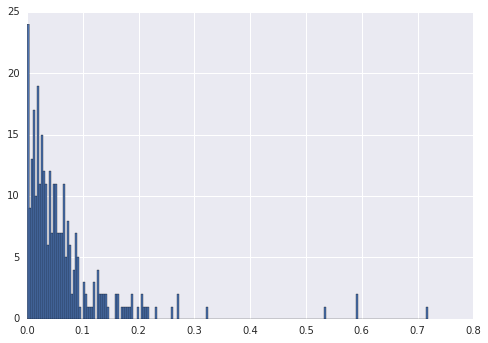

In [7]:
VDJ_df.max(axis=0).hist(bins=200)
plt.show()

In [8]:
t=0.01
count=0
for col in VDJ_df.columns:
    if VDJ_df[col].max()<t:
        print col
        count=count+1

print ('total col number: ', len(VDJ_df.columns))
print ('number of cols with max smaller than ',t,' ',count)

V03_0
V03-01_0
V03-02_0
V05-07_0
V01_J01_0
V03_J01_0
V03_J02_0
V16_J01_0
V20_J01_0
V20_J02_0
VA_J01_0
V03_1
V01-01_1
V03-02_1
V05-02_1
V05-03_1
V05-07_1
V06-07_1
V06-08_1
V06-09_1
V07-01_1
V07-04_1
V07-05_1
V07-07_1
V12-01_1
V12-02_1
V16-01_1
V23-01_1
V01_J01_1
V01_J02_1
V12_J01_1
V13_J01_1
V16_J01_1
V16_J02_1
V20_J01_1
V20_J02_1
V21_J01_1
V23_J01_1
V23_J02_1
V25_J01_1
('total col number: ', 308)
('number of cols with max smaller than ', 0.01, ' ', 40)


CONCLUSION: 0.01 is a good threshold- removing 40 columns out of 308

### remove rare columns from VDJ_db:

In [9]:
print ('n columns in VDJ_df',len(VDJ_df.columns))
for col in VDJ_df.columns:
    if VDJ_df[col].max()<0.01:
        VDJ_df=VDJ_df.drop(col,axis=1)
print ('n columns in VDJ_db',len(VDJ_df.columns))      

('n columns in VDJ_df', 308)
('n columns in VDJ_db', 268)


In [10]:
# save small rep feature:
folder='%s/TCR_real_data/Predictions/featureDFs/' %MyPath

F3='VDJ_no0-01rare.dat'
f3=folder+F3
VDJ_df.to_pickle(f3)

F4='VDJ_no0-01rare.xlsx'
f4=folder+F4
VDJ_df.to_excel(f4)

## analyze and process rep_features and VDJ dfs (remove correlated, fillnas, remove constant)

### small rep_feature df:

In [11]:
folder='%s/TCR_real_data/Predictions/featureDFs/' %MyPath

F1='allTCRfeatures_percShared10__withRels_noT.dat'
f1=folder+F1
allTCRfeatures_percShared10__withRels_noT=pd.read_pickle(f1)

featureDF=allTCRfeatures_percShared10__withRels_noT
featureDF,analysisDF, featureDFnameAddition=process_featureDF(featureDF,corrThreshold=1,removeCorr=True,exploreDF=True,deleteConsts=True,fillnans=True)

F2='allTCRfeatures_percShared10__withRels_noT_ANALYSIS.xlsx'
f2=folder+F2
analysisDF.to_excel(f2)

F3='allTCRfeatures_percShared10__withRels_noT'+featureDFnameAddition+'.dat'
f3=folder+F3
featureDF.to_pickle(f3)

removing all columns correlated to other column by r=1 or more
TCR feature DF shape after loading and before any removal  is 656_147
removing feature columns with less than 5 samples that are not nan...
[]
number of such columns is 0
TCRfeatureDF shape after removing all columns that dont have at least 5 valid values is 656_147
TCRfeatureDF2 shape before dropping highly correlated columns=656_147
filtering out columns with correlation larger than 1
TCRfeatureDF3 shape after dropping highly correlated columns=656_147
colToDrop list length with repeats: 0
colToDrop list length without repeats: 0
colToDrop list length without repeats and with nan columns: 0
[]
filling nans with 0...
number of columns to fill nans=143
total numvber of columns=147
exploring feature df...
(656, 147)
deleting constant variables...
constant variables are: []
featureDF shape before constant features removal is 656_147
Final featureDF shape  is 656_147
end of function!


### VDJ df:

In [12]:
folder='%s/TCR_real_data/Predictions/featureDFs/' %MyPath

F1='VDJ_no0-01rare.dat'
f1=folder+F1
VDJ_df=pd.read_pickle(f1)

featureDF=VDJ_df
featureDF,analysisDF, featureDFnameAddition=process_featureDF(featureDF,corrThreshold=1,removeCorr=True,exploreDF=True,deleteConsts=True,fillnans=True)

F2='VDJ_df_ANALYSIS.xlsx'
f2=folder+F2
analysisDF.to_excel(f2)

F3='VDJ_df'+featureDFnameAddition+'.dat'
f3=folder+F3
featureDF.to_pickle(f3)

removing all columns correlated to other column by r=1 or more
TCR feature DF shape after loading and before any removal  is 656_268
removing feature columns with less than 5 samples that are not nan...
[]
number of such columns is 0
TCRfeatureDF shape after removing all columns that dont have at least 5 valid values is 656_268
TCRfeatureDF2 shape before dropping highly correlated columns=656_268
filtering out columns with correlation larger than 1
TCRfeatureDF3 shape after dropping highly correlated columns=656_268
colToDrop list length with repeats: 0
colToDrop list length without repeats: 0
colToDrop list length without repeats and with nan columns: 0
[]
filling nans with 0...
number of columns to fill nans=268
total numvber of columns=268
exploring feature df...
(656, 268)
deleting constant variables...
constant variables are: []
featureDF shape before constant features removal is 656_268
Final featureDF shape  is 656_268
end of function!


## binarize VDJ_df:

In [13]:
F1='VDJ_no0-01rare.dat'
f1=folder+F1
VDJ_df=pd.read_pickle(f1)

In [15]:
VDJ_df_binary=pd.DataFrame(np.where(VDJ_df, 1, 0), VDJ_df.index, VDJ_df.columns)

In [22]:
folder='%s/TCR_real_data/Predictions/featureDFs/' %MyPath

F1='VDJ_no0-01rare_binary.dat'
f1=folder+F1
VDJ_df_binary.to_pickle(f1)

## generate seq cluster dfs

## correct for age, gender and eGFR: rep_features, VDJ, seqs, seq_clusters